## Notebook to answer question c: Who won each of the individual awards

In [347]:
# Load datasets
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

players_teams = pd.read_csv("project_data/players_teams.csv")
awards = pd.read_csv("project_data/awards_players.csv")
players = pd.read_csv("project_data/players_clean.csv")

### Attribute correlation players_teams table

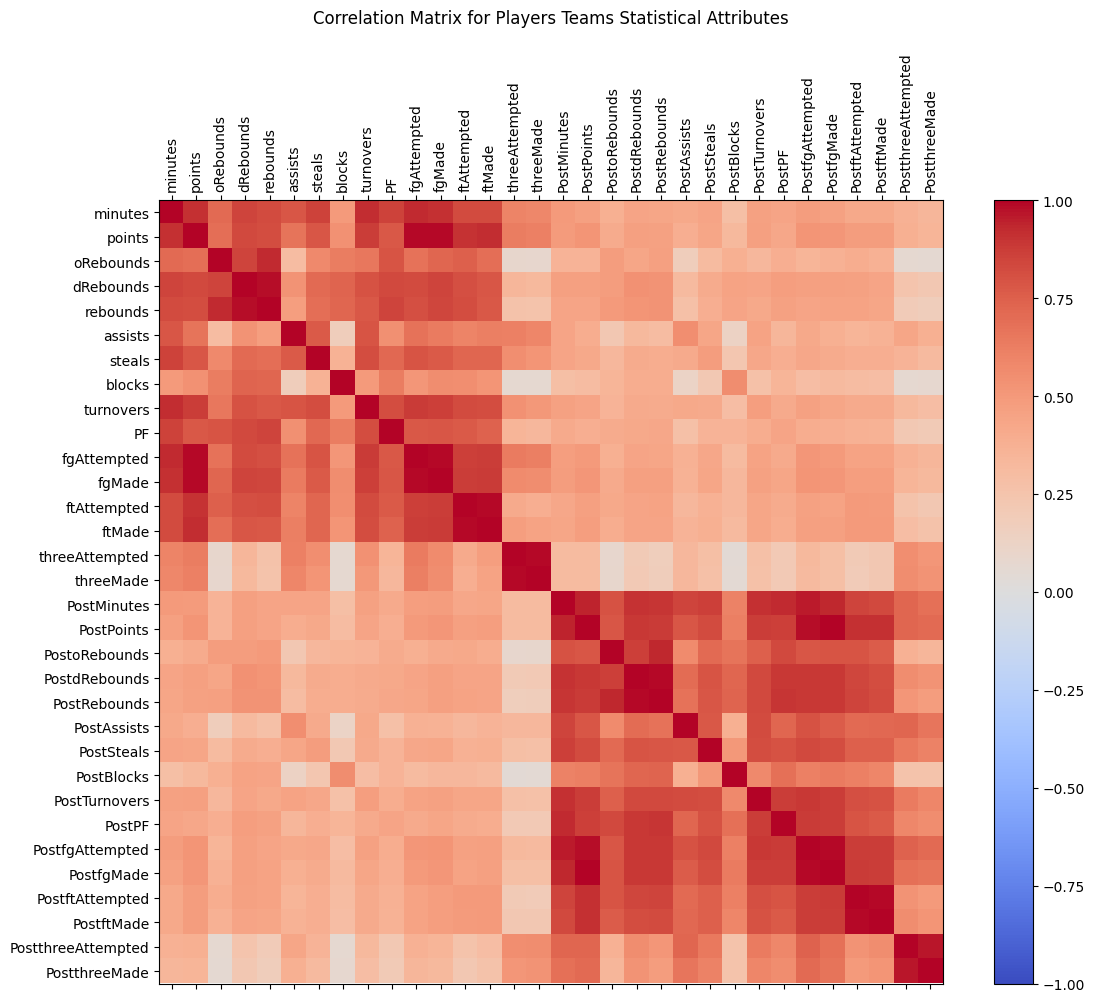

Correlation matrix includes 32 statistical attributes


In [348]:
# Since we use the players_teams dataset to calculate awards given each year and predict, we should check how each attribute correlates with others

# Select only numeric columns that represent basketball statistics (exclude IDs and categorical columns)
numeric_cols = players_teams.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-statistical columns like year and stint
cols_to_exclude = ['year', 'stint', 'GP', 'GS', 'dq', 'PostGP', 'PostGS', 'PostDQ']
stats_cols = [col for col in numeric_cols if col not in cols_to_exclude]

corr = players_teams[stats_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(stats_cols), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_cols, rotation=90)
ax.set_yticklabels(stats_cols)
plt.title('Correlation Matrix for Players Teams Statistical Attributes', pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix includes {len(stats_cols)} statistical attributes")


### Feature Selection for Prediction Models

Based on the correlation matrix above, we need to reduce the number of features to avoid multicollinearity and overfitting. We'll:
1. Identify highly correlated features (redundant information)
2. Create composite/engineered features (efficiency metrics)
3. Select the most important features for prediction

In [349]:
# Step 1: Identify highly correlated features (>0.85 correlation)
# These features provide redundant information

def find_high_correlation_pairs(corr_matrix, threshold=0.85):
    """Find pairs of features with correlation above threshold"""
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

"""
high_corr = find_high_correlation_pairs(corr, threshold=0.85)
print("Highly correlated feature pairs (>0.85):")
print(high_corr.to_string())
print(f"\nTotal pairs: {len(high_corr)}")
"""

def find_high_correlation_many(corr_matrix, threshold=0.85):
    """ Find sets of features that are all highly correlated with each other """
    visited = set()
    high_corr_sets = []

    for i in range(len(corr_matrix.columns)):
        if corr_matrix.columns[i] in visited:
            continue
        current_set = {corr_matrix.columns[i]}
        for j in range(len(corr_matrix.columns)):
            if i != j and abs(corr_matrix.iloc[i, j]) > threshold:
                current_set.add(corr_matrix.columns[j])
                visited.add(corr_matrix.columns[j])
        if len(current_set) > 1:
            high_corr_sets.append(current_set)
            visited.update(current_set)

    return high_corr_sets

high_corr_sets = find_high_correlation_many(corr, threshold=0.90)
print("\nSets of highly correlated features (>0.90):")
for s in high_corr_sets:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets)}")

high_corr_sets2 = find_high_correlation_many(corr, threshold=0.85)
print("\nSets of highly correlated features (>0.85):")
for s in high_corr_sets2:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets2)}")

high_corr_sets3 = find_high_correlation_many(corr, threshold=0.80)
print("\nSets of highly correlated features (>0.80):")
for s in high_corr_sets3:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets3)}")



Sets of highly correlated features (>0.90):
{'turnovers', 'fgAttempted', 'points', 'minutes', 'fgMade'}
{'rebounds', 'oRebounds'}
{'rebounds', 'dRebounds'}
{'points', 'ftAttempted', 'ftMade'}
{'threeAttempted', 'threeMade'}
{'PostPoints', 'PostTurnovers', 'PostfgMade', 'PostfgAttempted', 'PostMinutes', 'PostPF'}
{'PostRebounds', 'PostoRebounds'}
{'PostRebounds', 'PostdRebounds'}
{'PostPoints', 'PostftMade', 'PostftAttempted'}
{'PostthreeMade', 'PostthreeAttempted'}

Total sets: 10

Sets of highly correlated features (>0.85):
{'turnovers', 'fgAttempted', 'fgMade', 'points', 'steals', 'PF', 'minutes'}
{'rebounds', 'oRebounds'}
{'rebounds', 'dRebounds'}
{'fgAttempted', 'ftAttempted', 'points', 'ftMade', 'fgMade'}
{'threeAttempted', 'threeMade'}
{'PostSteals', 'PostPoints', 'PostTurnovers', 'PostdRebounds', 'PostfgMade', 'PostfgAttempted', 'PostMinutes', 'PostRebounds', 'PostPF'}
{'PostRebounds', 'PostoRebounds', 'PostdRebounds'}
{'PostPoints', 'PostfgMade', 'PostfgAttempted', 'PostftAtte

### Creating new dataset with engineered features for awards

In [350]:
# Create a new DataFrame with selected + engineered features
players_teams_clean = pd.DataFrame({
    "playerID": players_teams["playerID"],
    "year": players_teams["year"],
    "team": players_teams["tmID"],
    
    # Playing time (IMPORTANT: helps filter out anomalies)
    "minutes": players_teams["minutes"],
    "games_played": players_teams["GP"],
    "minutes": players_teams["minutes"],  # For filtering and weighting
    "total_points": players_teams["points"],  # Raw volume stats
    "total_rebounds": players_teams["rebounds"],
    "total_assists": players_teams["assists"],

    # Per-minute efficiency stats
    "points_per_min": players_teams["points"] / players_teams["minutes"],
    "assists_per_min": players_teams["assists"] / players_teams["minutes"],
    "rebounds_per_min": players_teams["rebounds"] / players_teams["minutes"],
    "steals_per_min": players_teams["steals"] / players_teams["minutes"],
    "blocks_per_min": players_teams["blocks"] / players_teams["minutes"],
    "turnovers_per_min": players_teams["turnovers"] / players_teams["minutes"],

    # Shooting efficiencies
    "FG%": players_teams["fgMade"] / players_teams["fgAttempted"],
    "FT%": players_teams["ftMade"] / players_teams["ftAttempted"],
    "Three%": players_teams["threeMade"] / players_teams["threeAttempted"],

    # Play style
    "Three Rate": players_teams["threeAttempted"] / players_teams["fgAttempted"],  # share of shots from 3s
})

# Handle any divide-by-zero or NaN issues
players_teams_clean = players_teams_clean.replace([float('inf'), -float('inf')], pd.NA).fillna(0)

# Save dataframe
players_teams_clean.to_csv("project_data/awards_data/players_teams_clean.csv", index=False)

# Show statistics about playing time
print("Playing Time Statistics:")
print(f"Min minutes: {players_teams_clean['minutes'].min()}")
print(f"Max minutes: {players_teams_clean['minutes'].max()}")
print(f"Mean minutes: {players_teams_clean['minutes'].mean():.1f}")
print(f"Median minutes: {players_teams_clean['minutes'].median():.1f}")
print(f"\nPlayers with < 100 minutes: {(players_teams_clean['minutes'] < 100).sum()}")
print(f"Players with < 200 minutes: {(players_teams_clean['minutes'] < 200).sum()}")

# Save or preview
print("\nSample of data:")
print(players_teams_clean.head(10))

Playing Time Statistics:
Min minutes: 0
Max minutes: 1234
Mean minutes: 501.3
Median minutes: 459.0

Players with < 100 minutes: 330
Players with < 200 minutes: 535

Sample of data:
     playerID  year team  minutes  games_played  total_points  total_rebounds  \
0  abrossv01w     2  MIN      846            26           343             174   
1  abrossv01w     3  MIN      805            27           314             146   
2  abrossv01w     4  MIN      792            30           318             141   
3  abrossv01w     5  MIN      462            22           146              74   
4  abrossv01w     6  MIN      777            31           304             107   
5  abrossv01w     7  MIN      724            34           263             106   
6  abrossv01w     8  MIN      843            34           345             150   
7  abrossv01w     9  CON      107             6            34              20   
8  adamsjo01w     4  MIN       96            10            33              23   
9  aguil

### Correlation Matrix for the newly created dataframe

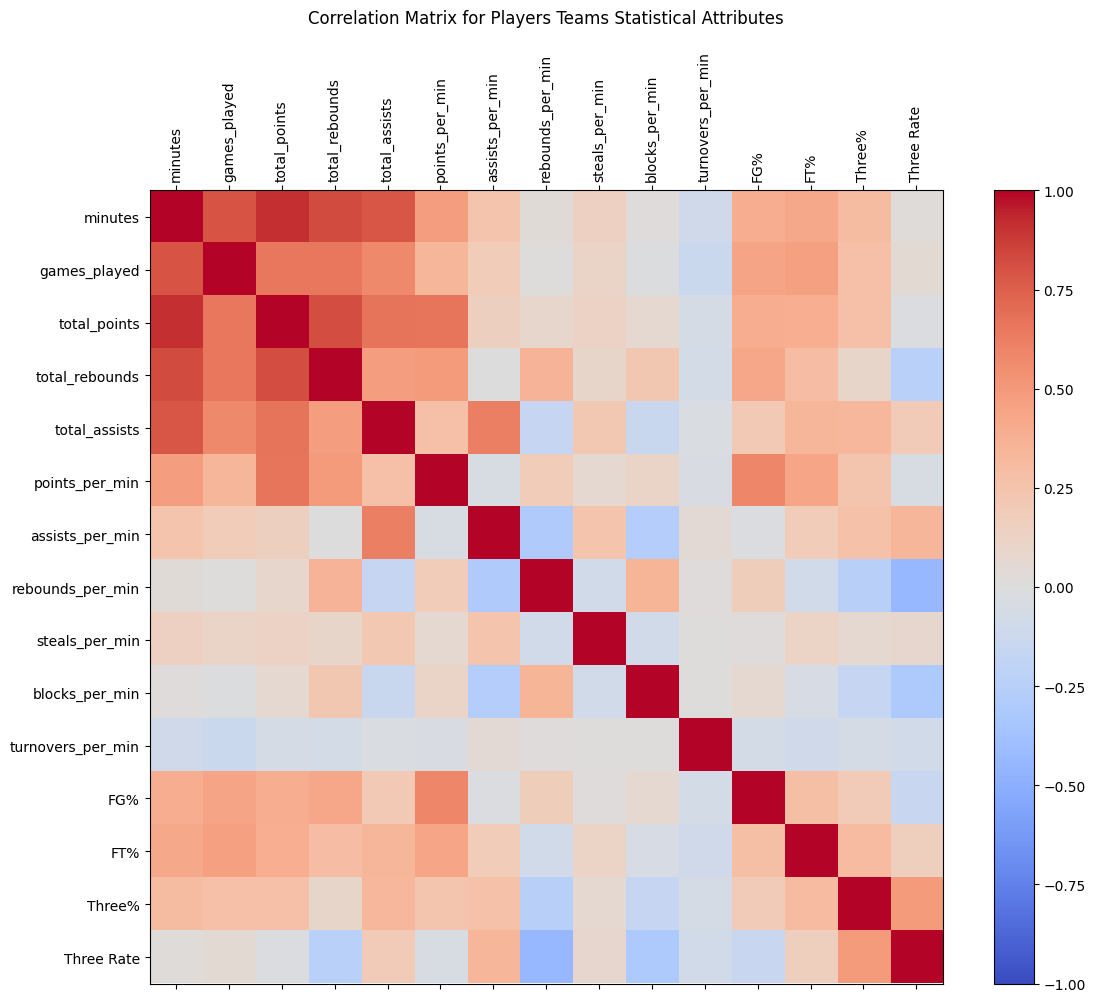

Correlation matrix includes 15 statistical attributes


In [351]:
# Find high corr sets of players_teams_clean

# Since we use the players_teams dataset to calculate awards given each year and predict, we should check how each attribute correlates with others

# Select only numeric columns that represent basketball statistics (exclude IDs and categorical columns)
numeric_cols = players_teams_clean.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-statistical columns like year and stint
cols_to_exclude = ['year', 'stint', 'GP', 'GS', 'dq', 'PostGP', 'PostGS', 'PostDQ']
stats_cols = [col for col in numeric_cols if col not in cols_to_exclude]

corr = players_teams_clean[stats_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(stats_cols), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_cols, rotation=90)
ax.set_yticklabels(stats_cols)
plt.title('Correlation Matrix for Players Teams Statistical Attributes', pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix includes {len(stats_cols)} statistical attributes")


### 1. Rookie of the Year Award

In [352]:
# Function to identify rookies by year
def get_rookies_by_year(players_teams):
    players_teams = players_teams.sort_values(by=['year'])
    rookies_by_year = {}
    min_year = players_teams['year'].min()
    max_year = players_teams['year'].max()
    previous_years_players = set()

    for year in range(min_year + 1, max_year + 1):
        current_years = players_teams[players_teams['year'] == year]
        current_years_players = set(current_years['playerID'])

        rookies = current_years_players - previous_years_players
        rookies_by_year[year] = rookies

        previous_years_players.update(current_years_players)

    return rookies_by_year

rookies_by_year = get_rookies_by_year(players_teams)

for year, rookies in rookies_by_year.items():
    print(f"Year: {year}")
    print(f"Rookies: {rookies}")

Year: 2
Rookies: {'schumke01w', 'williwe01w', 'reidtr01w', 'darlihe01w', 'henniso01w', 'erbsu01w', 'milleke01w', 'mcwilta01w', 'smithch03w', 'dickeke01w', 'colleka01w', 'consuca01w', 'thomast01w', 'torniel01w', 'washito01w', 'feastal01w', 'brondsa01w', 'campbed01w', 'johnsti01w', 'jacksta01w', 'edwarmi01w', 'douglka01w', 'wynneda01w', 'badertr01w', 'streiju01w', 'radunha01w', 'pettibr01w', 'pavlimi01w', 'stafftr01w', 'phillta01w', 'marcimi01w', 'crawlsy01w', 'hallvi01w', 'milleco01w', 'hledeko01w', 'griffyo01w', 'nemcoev01w', 'weathte01w', 'scottol01w', 'williri01w', 'willina01w', 'machacl01w', 'brumfma01w', 'pagemu01w', 'boltoru01w', 'stockta01w', 'hollake01w', 'figgsuk01w', 'schwege01w', 'wolteka01w', 'mabikmw01w', 'dossaci01w', 'whitmta01w', 'torrele01w', 'nolande01w', 'brownru01w', 'blackde01w', 'alhalta01w', 'shakiel01w', 'penicti01w', 'fordst01w', 'stinsan01w', 'martima01w', 'williad01w', 'mapprh01w', 'frettla01w', 'tuvicsl01w', 'bristre01w', 'mcgheca01w', 'smithch02w', 'palmewe0

In [353]:
# Calculate Performance of Rookies in all years
# Performance Formula : ((Points + Rebounds + Assists + Steals + Blocks) - ((Field Goals Att. - Field Goals Made) + (Free Throws Att. - Free Throws Made) + Turnovers))

rookie_performance = {}

# Function to calculate performance for a single player in a given year
# EFF_per_min=points_per_min+rebounds_per_min+assists_per_min+steals_per_min+blocks_per_min‚àíturnovers_per_min
def calculate_player_yearly_performance(year, player_id):
    stats = players_teams_clean[(players_teams_clean['year'] == year) & (players_teams_clean['playerID'] == player_id)]
    if stats.empty:
        return 0
    points = stats['points_per_min'].values[0]
    assists = stats['assists_per_min'].values[0]
    rebounds = stats['rebounds_per_min'].values[0]
    steals = stats['steals_per_min'].values[0]
    blocks = stats['blocks_per_min'].values[0]
    turnovers = stats['turnovers_per_min'].values[0]
    
    FG_perc = stats['FG%'].values[0]
    FT_perc = stats['FT%'].values[0]
    Three_perc = stats['Three%'].values[0]
    Three_Rate = stats['Three Rate'].values[0]

    base = points + rebounds + assists + steals + blocks - turnovers
    efficiency_multiplier = 0.5 + 0.5 * FG_perc
    shooting_bonus = 0.2 * Three_perc + 0.1 * FT_perc + 0.05 * Three_Rate

    performance_score = base * efficiency_multiplier + shooting_bonus

    return performance_score

# Function to calculate performance for all rookies in a given year
def calculate_rookies_yearly_performance(year, players_teams):
    rookies = get_rookies_by_year(players_teams).get(year, [])
    for rookie in rookies:
        performance = calculate_player_yearly_performance(year, rookie)
        rookie_performance[(year, rookie)] = performance
    return rookie_performance

for year, rookies in rookies_by_year.items():
    rookie_performance = calculate_rookies_yearly_performance(year, players_teams)

# ADJUST THIS THRESHOLD TO FILTER OUT ANOMALIES (players with too few minutes)
MIN_MINUTES_THRESHOLD = 300

# Display Rookie of the Year for each year
rookie_of_the_year = {}
for year, rookies in rookies_by_year.items():
    best_rookie = None
    best_performance = float('-inf')
    for rookie in rookies:
        # Get rookie's minutes to filter out anomalies
        rookie_stats = players_teams_clean[(players_teams_clean['year'] == year) & 
                                          (players_teams_clean['playerID'] == rookie)]
        
        # Skip rookies with too few minutes (likely anomalies)
        if not rookie_stats.empty and rookie_stats['minutes'].values[0] < MIN_MINUTES_THRESHOLD:
            continue
            
        performance = rookie_performance.get((year, rookie), 0)
        if performance > best_performance:
            best_performance = performance
            best_rookie = rookie
    rookie_of_the_year[year] = (best_rookie, best_performance)

# Compare with actual awards data
print("=" * 100)
print(f"üîß MIN_MINUTES_THRESHOLD = {MIN_MINUTES_THRESHOLD} (players below this are filtered out)")
print("=" * 100)
print("\nComparison with Actual Awards Data:\n")

actual_awards = awards[awards['award'] == 'Rookie of the Year']
actual_awards = actual_awards[['year', 'playerID']]
actual_awards_dict = dict(zip(actual_awards['year'], actual_awards['playerID']))

correct_predictions = 0
total_predictions = 0
filtered_out_winners = 0

for year, (predicted_rookie, _) in rookie_of_the_year.items():
    actual_rookie = actual_awards_dict.get(year)
    total_predictions += 1
    
    # Check if actual winner was filtered out due to minutes threshold
    actual_winner_stats = players_teams_clean[(players_teams_clean['year'] == year) & 
                                              (players_teams_clean['playerID'] == actual_rookie)]
    actual_winner_minutes = actual_winner_stats['minutes'].values[0] if not actual_winner_stats.empty else 0
    was_filtered_out = actual_winner_minutes < MIN_MINUTES_THRESHOLD

    if actual_rookie == predicted_rookie:
        correct_predictions += 1
        predicted_perf = rookie_performance.get((year, predicted_rookie), 'N/A')
        print(
            f"Year {year}: Predicted: {predicted_rookie} ‚úÖ CORRECT "
            f"(Score: {predicted_perf:.4f})"
        )
    else:
        actual_perf = rookie_performance.get((year, actual_rookie), 'N/A')
        predicted_perf = rookie_performance.get((year, predicted_rookie), 'N/A')
        
        if was_filtered_out:
            filtered_out_winners += 1
            print(
                f"Year {year}: Predicted: {predicted_rookie} ‚ùå INCORRECT "
                f"(Actual: {actual_rookie}) ‚ö†Ô∏è FILTERED OUT ({actual_winner_minutes:} min < {MIN_MINUTES_THRESHOLD})"
            )
        else:
            print(
                f"Year {year}: Predicted: {predicted_rookie} ‚ùå INCORRECT "
                f"(Actual: {actual_rookie}), Scores: Actual={actual_perf}, Pred={predicted_perf}"
            )



üîß MIN_MINUTES_THRESHOLD = 300 (players below this are filtered out)

Comparison with Actual Awards Data:

Year 2: Predicted: leslili01w ‚ùå INCORRECT (Actual: stileja01w), Scores: Actual=0.5699139382618755, Pred=0.8550079879607599
Year 3: Predicted: catchta01w ‚úÖ CORRECT (Score: 0.8164)
Year 4: Predicted: fordch01w ‚úÖ CORRECT (Score: 0.5994)
Year 5: Predicted: tauradi01w ‚úÖ CORRECT (Score: 0.6849)
Year 6: Predicted: batkosu01w ‚ùå INCORRECT (Actual: johnste01w), Scores: Actual=0.5614168024825544, Pred=0.6478732782663519
Year 7: Predicted: augusse01w ‚úÖ CORRECT (Score: 0.7438)
Year 8: Predicted: spencsi01w ‚ùå INCORRECT (Actual: pricear01w), Scores: Actual=0.5609119297401721, Pred=0.6255063963372552
Year 9: Predicted: parkeca01w ‚úÖ CORRECT (Score: 0.8885)
Year 10: Predicted: mccouan01w ‚úÖ CORRECT (Score: 0.7681)


## Prediction Models

### Rookie of the Year

#### 1. Logistic Regression

In [354]:
# Prepare data for Logistic Regression model to predict Rookie of the Year

# Step 1: Get rookies from players_teams_clean
rookies_by_year_clean = get_rookies_by_year(players_teams_clean)

# Step 2: Create a dataset with all rookies and their stats
all_rookies_data = []

for year, rookies in rookies_by_year_clean.items():
    for rookie in rookies:
        rookie_stats = players_teams_clean[(players_teams_clean['year'] == year) & 
                                           (players_teams_clean['playerID'] == rookie)]
        
        if not rookie_stats.empty:
            # Get the rookie's stats
            stats_dict = {
                'playerID': rookie,
                'year': year,
                'minutes': rookie_stats['minutes'].values[0],
                'games_played': rookie_stats['games_played'].values[0],
                'total_points': rookie_stats['total_points'].values[0],
                'total_rebounds': rookie_stats['total_rebounds'].values[0],
                'total_assists': rookie_stats['total_assists'].values[0],
                'points_per_min': rookie_stats['points_per_min'].values[0],
                'assists_per_min': rookie_stats['assists_per_min'].values[0],
                'rebounds_per_min': rookie_stats['rebounds_per_min'].values[0],
                'steals_per_min': rookie_stats['steals_per_min'].values[0],
                'blocks_per_min': rookie_stats['blocks_per_min'].values[0],
                'turnovers_per_min': rookie_stats['turnovers_per_min'].values[0],
                'FG%': rookie_stats['FG%'].values[0],
                'FT%': rookie_stats['FT%'].values[0],
                'Three%': rookie_stats['Three%'].values[0],
                'Three Rate': rookie_stats['Three Rate'].values[0],
            }
            all_rookies_data.append(stats_dict)

# Create DataFrame with all rookies
df_rookies = pd.DataFrame(all_rookies_data)

# Step 3: Add target variable (1 if won ROY, 0 otherwise)
roy_winners = awards[awards['award'] == 'Rookie of the Year'][['year', 'playerID']]

# Create ROY_winner column
df_rookies['ROY_winner'] = df_rookies.apply(
    lambda row: 1 if ((roy_winners['year'] == row['year']) & 
                      (roy_winners['playerID'] == row['playerID'])).any() else 0,
    axis=1
)

# Step 4: Filter out players with too few minutes (anomalies)
MIN_MINUTES_FOR_MODEL = 300  # Adjust as needed
df_rookies = df_rookies[df_rookies['minutes'] >= MIN_MINUTES_FOR_MODEL].copy()

print(f"Total rookies in dataset: {len(df_rookies)}")
print(f"ROY winners in dataset: {df_rookies['ROY_winner'].sum()}")
print(f"\nClass distribution:")
print(df_rookies['ROY_winner'].value_counts())
print(f"\nDataset shape: {df_rookies.shape}")
print(f"\nSample of data:")
print(df_rookies.head())

Total rookies in dataset: 256
ROY winners in dataset: 9

Class distribution:
ROY_winner
0    247
1      9
Name: count, dtype: int64

Dataset shape: (256, 18)

Sample of data:
     playerID  year  minutes  games_played  total_points  total_rebounds  \
0  schumke01w     2      380            28           112              70   
3  darlihe01w     2      778            32           196              76   
4  henniso01w     2      902            32           108              71   
7  mcwilta01w     2     1059            32           403             243   
8  smithch03w     2      589            32            58              55   

   total_assists  points_per_min  assists_per_min  rebounds_per_min  \
0             10        0.294737         0.026316          0.184211   
3            109        0.251928         0.140103          0.097686   
4             93        0.119734         0.103104          0.078714   
7             69        0.380548         0.065156          0.229462   
8            

In [355]:
# Train Logistic Regression model for Rookie of the Year prediction

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Select features for the model
# OPTION 1: Use combination of per-minute and totals (recommended)
feature_columns_combined = [
    'minutes',  # Playing time is important
    'total_points', 'total_rebounds', 'total_assists',  # Raw production
    'points_per_min', 'rebounds_per_min', 'assists_per_min',  # Efficiency
    'steals_per_min', 'blocks_per_min',  # Defense
    'FG%', 'Three%',  # Shooting efficiency
]

# OPTION 2: Use per-minute stats only (efficiency focus)
feature_columns_efficiency = [
    'points_per_min', 'rebounds_per_min', 'assists_per_min',
    'steals_per_min', 'blocks_per_min', 'turnovers_per_min',
    'FG%', 'FT%', 'Three%', 'Three Rate',
]

# Choose which features to use
#feature_columns = feature_columns_combined  # Change to feature_columns_efficiency to test
feature_columns = feature_columns_efficiency  # Change to feature_columns_efficiency to test

# Prepare X and y
X = df_rookies[feature_columns]
y = df_rookies['ROY_winner']

# Split into train/test by year (more realistic than random split)
train_years = [2, 3, 4, 5, 8, 9, 10]
test_years = [6, 7]

X_train = df_rookies[df_rookies['year'].isin(train_years)][feature_columns]
y_train = df_rookies[df_rookies['year'].isin(train_years)]['ROY_winner']
X_test = df_rookies[df_rookies['year'].isin(test_years)][feature_columns]
y_test = df_rookies[df_rookies['year'].isin(test_years)]['ROY_winner']

print(f"Training set: {len(X_train)} rookies, {y_train.sum()} winners")
print(f"Test set: {len(X_test)} rookies, {y_test.sum()} winners")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model with class_weight='balanced' to handle imbalanced data
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_train_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Predictions (using default threshold 0.5)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("\n" + "=" * 80)
print("MODEL EVALUATION:")
print("=" * 80)

print("\nTRAINING SET PERFORMANCE:")
print(classification_report(y_train, y_train_pred, target_names=['Not ROY', 'ROY Winner']))

print("\nTEST SET PERFORMANCE:")
print(classification_report(y_test, y_test_pred, target_names=['Not ROY', 'ROY Winner']))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Feature importance (coefficients)
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE (Model Coefficients):")
print("=" * 80)
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print(feature_importance.to_string(index=False))

Training set: 229 rookies, 7 winners
Test set: 27 rookies, 2 winners

MODEL EVALUATION:

TRAINING SET PERFORMANCE:
              precision    recall  f1-score   support

     Not ROY       1.00      0.86      0.92       222
  ROY Winner       0.18      1.00      0.30         7

    accuracy                           0.86       229
   macro avg       0.59      0.93      0.61       229
weighted avg       0.97      0.86      0.90       229


TEST SET PERFORMANCE:
              precision    recall  f1-score   support

     Not ROY       0.96      0.92      0.94        25
  ROY Winner       0.33      0.50      0.40         2

    accuracy                           0.89        27
   macro avg       0.65      0.71      0.67        27
weighted avg       0.91      0.89      0.90        27


Confusion Matrix (Test Set):
[[23  2]
 [ 1  1]]

FEATURE IMPORTANCE (Model Coefficients):
          Feature  Coefficient
   points_per_min     2.488463
 rebounds_per_min     1.434410
           Three%     0.

In [356]:
# Predict Rookie of the Year for each test year and compare with actual winners

print("=" * 100)
print("ROOKIE OF THE YEAR PREDICTIONS BY YEAR (Test Set)")
print("=" * 100)

# Get predictions for test years
test_data = df_rookies[df_rookies['year'].isin(test_years)].copy()
test_data_scaled = scaler.transform(test_data[feature_columns])
test_data['predicted_prob'] = model.predict_proba(test_data_scaled)[:, 1]

# For each test year, find the rookie with highest probability
for year in test_years:
    year_rookies = test_data[test_data['year'] == year].copy()
    year_rookies = year_rookies.sort_values('predicted_prob', ascending=False)
    
    # Get actual winner
    actual_winner = roy_winners[roy_winners['year'] == year]['playerID'].values
    actual_winner = actual_winner[0] if len(actual_winner) > 0 else None
    
    # Get predicted winner (highest probability)
    predicted_winner = year_rookies.iloc[0]['playerID']
    predicted_prob = year_rookies.iloc[0]['predicted_prob']
    
    # Check if correct
    is_correct = predicted_winner == actual_winner
    
    # Get actual winner's probability and rank
    actual_winner_row = year_rookies[year_rookies['playerID'] == actual_winner]
    if not actual_winner_row.empty:
        actual_prob = actual_winner_row['predicted_prob'].values[0]
        actual_rank = (year_rookies['predicted_prob'] > actual_prob).sum() + 1
    else:
        actual_prob = None
        actual_rank = None
    
    print(f"\nYear {year}:")
    print(f"  Predicted: {predicted_winner} (probability: {predicted_prob:.6f})")
    if not is_correct and actual_prob is not None:
        print(f"  Actual:    {actual_winner} (probability: {actual_prob:.6f}, rank: #{actual_rank})")
        print(f"  Difference: {abs(predicted_prob - actual_prob):.6f} (very close!)" if abs(predicted_prob - actual_prob) < 0.01 else "")
    else:
        print(f"  Actual:    {actual_winner}")
    print(f"  Result:    {'‚úÖ CORRECT' if is_correct else '‚ùå INCORRECT'}")
    
    # Show top 5 rookies by predicted probability
    print(f"\n  Top 5 candidates:")
    for idx, (i, row) in enumerate(year_rookies.head(5).iterrows(), 1):
        is_actual = row['playerID'] == actual_winner
        marker = "‚≠ê" if is_actual else "  "
        print(f"    {marker} {idx}. {row['playerID']:20s} - Prob: {row['predicted_prob']:.6f} "
              f"(Pts/min: {row['points_per_min']:.3f}, Min: {row['minutes']:.0f})")

ROOKIE OF THE YEAR PREDICTIONS BY YEAR (Test Set)

Year 6:
  Predicted: braxtka01w (probability: 0.902084)
  Actual:    johnste01w (probability: 0.114437, rank: #4)

  Result:    ‚ùå INCORRECT

  Top 5 candidates:
       1. braxtka01w           - Prob: 0.902084 (Pts/min: 0.499, Min: 455)
       2. lyttlsa01w           - Prob: 0.450048 (Pts/min: 0.304, Min: 460)
       3. batkosu01w           - Prob: 0.277327 (Pts/min: 0.432, Min: 461)
    ‚≠ê 4. johnste01w           - Prob: 0.114437 (Pts/min: 0.324, Min: 973)
       5. whiteta01w           - Prob: 0.017949 (Pts/min: 0.349, Min: 693)

Year 7:
  Predicted: augusse01w (probability: 0.971254)
  Actual:    augusse01w
  Result:    ‚úÖ CORRECT

  Top 5 candidates:
    ‚≠ê 1. augusse01w           - Prob: 0.971254 (Pts/min: 0.662, Min: 1124)
       2. pondeca01w           - Prob: 0.953448 (Pts/min: 0.585, Min: 1067)
       3. currimo01w           - Prob: 0.483462 (Pts/min: 0.402, Min: 844)
       4. youngso01w           - Prob: 0.410293 (Pts/mi